# MARATÓN BEHIND THE CODE 2020

## DESAFÍO 2: PARTE 1

### Introducción

En proyectos de ciencia de datos destinados a construir modelos de *aprendizaje automático*, o aprendizaje estadístico, es muy inusual que los datos iniciales ya estén en el formato ideal para la construcción de modelos. Se requieren varios pasos intermedios de preprocesamiento de datos, como la codificación de variables categóricas, normalización de variables numéricas, tratamiento de datos faltantes, etc. La biblioteca **scikit-learn**, una de las bibliotecas de código abierto más populares para *aprendizaje automático* en el mundo, ya tiene varias funciones integradas para realizar las transformaciones de datos más utilizadas. Sin embargo, en un flujo común de un modelo de aprendizaje automático, es necesario aplicar estas transformaciones al menos dos veces: la primera vez para "entrenar" el modelo, y luego nuevamente cuando se envían nuevos datos como entrada para ser clasificados por este modelo.

Para facilitar el trabajo con este tipo de flujos, scikit-learn también cuenta con una herramienta llamada **Pipeline**, que no es más que una lista ordenada de transformaciones que se deben aplicar a los datos. Para ayudar en el desarrollo y la gestión de todo el ciclo de vida de estas aplicaciones, además del uso de Pipelines, los equipos de científicos de datos pueden utilizar en conjunto **Watson Machine Learning**, que tiene docenas de herramientas para entrenar , gestionar, alojar y evaluar modelos basados ​​en el aprendizaje automático. Además, Watson Machine Learning es capaz de encapsular pipelines y modelos en una API lista para usar e integrarse con otras aplicaciones.

Durante el desafío 2, aprenderás como crear un **Pipeline** para un modelo de clasificación y alojarlo como una API con la ayuda de Watson Machine Learning. Una vez alojado, puedes integrar el modelo creado con otras aplicaciones, como asistentes virtuales y más. En este notebook, se presentará un ejemplo funcional de creación de un modelo y un pipeline en scikit-learn (¡que puedes usar como plantilla para tu solución!).

### Trabajando con Pipelines del scikit-learn

In [162]:
# Primero, realizamos la instalación de scikit-learn versión 0.20.0 en el Kernel de este notebook:
!pip install scikit-learn==0.20.0 --upgrade

Requirement already up-to-date: scikit-learn==0.20.0 in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.20.0)


In [163]:
# A continuación importaremos varias bibliotecas que se utilizarán:

# Biblioteca para trabajar con JSON
import json

# Biblioteca para realizar solicitudes HTTP
import requests

# Biblioteca para exploración y análisis de datos
import pandas as pd

# Biblioteca con métodos numéricos y representaciones matriciales
import numpy as np

# Biblioteca para construir un modelo basado en la técnica Gradient Boosting
import xgboost as xgb

# Paquetes scikit-learn para preprocesamiento de datos
# "SimpleImputer" es una transformación para completar los valores faltantes en conjuntos de datos
from sklearn.impute import SimpleImputer

# Paquetes de scikit-learn para entrenamiento de modelos y construcción de pipelines
# Método para separar el conjunto de datos en muestras de testes y entrenamiento
from sklearn.model_selection import train_test_split
# Método para crear modelos basados en árboles de decisión
from sklearn.tree import DecisionTreeClassifier
# Clase para crear una pipeline de machine-learning
from sklearn.pipeline import Pipeline

# Paquetes scikit-learn para evaluación de modelos
# Métodos para la validación cruzada del modelo creado
from sklearn.model_selection import KFold, cross_validate

### Importar  un .csv a tu proyecto en IBM Cloud Pak for Data al Kernel de este notebook

Primero, importaremos el conjunto de datos proporcionado para el desafío, que ya está incluido en este proyecto.

Puedes importar datos desde un archivo .csv directamente al Kernel del portátil como un Pandas DataFrame, que se usa ampliamente para manipular datos en Python.

Para realizar la importación, simplemente selecciona la siguiente celda y siga las instrucciones en la imagen a continuación:

![alt text](https://i.imgur.com/K1DwL9I.png "importing-csv-as-df")

Después de seleccionar la opción **"Insertar en el código"**, la celda de abajo se llenará con el código necesario para importar y leer los datos en el archivo .csv como un Pandas DataFrame.

In [164]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,NAME,USER_ID,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND,PROFILE
0,28,Stormy Muto,58283940,7.0,39.0,29.0,2.0,4.0,0.0,2.0,5.0,0.0,84.0,74.0,NaN,beginner_front_end
1,81,Carlos Ferro,1357218,32.0,0.0,44.0,2.0,0.0,0.0,0.0,5.0,0.0,67.0,45.0,NaN,beginner_front_end
2,89,Robby Constantini,63212105,45.0,0.0,59.0,0.0,5.0,4.0,0.0,4.0,1.0,NaN,54.0,47.0,advanced_front_end
3,138,Paul Mckenny,23239851,36.0,19.0,28.0,0.0,5.0,7.0,0.0,5.0,3.0,NaN,71.0,89.0,beginner_data_science
4,143,Jean Webb,72234478,61.0,78.0,38.0,6.0,11.0,0.0,4.0,3.0,0.0,66.0,85.0,NaN,advanced_front_end


Tenemos 16 columnas presentes en el set de datos proporcionado, 15 de las cuales son variables features (datos de entrada) y una de ellas es una variable target (que queremos que nuestro modelo va a predecir).

Las variables features son:

    Unnamed: 0                          - Esta columna no tiene nombre y debe ser eliminada del dataset
    NAME                                - Nombre del estudiante
    USER_ID                             - Número de identificación del estudiante
    HOURS_DATASCIENCE                   - Número de horas de estudio en Data Science
    HOURS_BACKEND                       - Número de horas de estudio en Web (Back-End)
    HOURS_FRONTEND                      - Número de horas de estudio en Web (Front-End)
    NUM_COURSES_BEGINNER_DATASCIENCE    - Número de cursos de nivel principiante en Data Science completados por el estudiante
    NUM_COURSES_BEGINNER_BACKEND        - Número de cursos de nivel principiante en Web (Back-End) completados por el estudiante
    NUM_COURSES_BEGINNER_FRONTEND       - Número de cursos de nivel principiante en Web (Front-End) completados por el estudiante
    NUM_COURSES_ADVANCED_DATASCIENCE    - Número de cursos de nivel avanzado en Data Science completados por el estudiante
    NUM_COURSES_ADVANCED_BACKEND        - Número de cursos de nivel avanzado en Web (Back-End) completados por el estudiante
    NUM_COURSES_ADVANCED_FRONTEND       - Número de cursos de nivel avanzado en Web (Front-End) completados por el estudiante
    AVG_SCORE_DATASCIENCE               - Promedio acumulado en cursos de Data Science completados por el estudiante
    AVG_SCORE_BACKEND                   - Promedio acumulado en cursos de Web (Back-End) completados por el estudiante
    AVG_SCORE_FRONTEND                  - Promedio acumulado en cursos de Web (Front-End) completados por el estudiante
    
La variable target es:

    PROFILE                             - Perfil de carrera del estudiante (puede ser uno de 6)
    
        - beginner_front_end
        - advanced_front_end
        - beginner_back_end
        - advanced_back_end
        - beginner_data_science
        - advanced_data_science
        
Con un modelo capaz de clasificar a un alumno en una de estas categorías, podemos recomendar contenidos a los alumnos de forma personalizada según las necesidades de cada alumno.

### Explorando los datos proporcionados

Podemos continuar la exploración de los datos proporcionados con la función ``info()``:

In [165]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
Unnamed: 0                          20000 non-null int64
NAME                                20000 non-null object
USER_ID                             20000 non-null int64
HOURS_DATASCIENCE                   19986 non-null float64
HOURS_BACKEND                       19947 non-null float64
HOURS_FRONTEND                      19984 non-null float64
NUM_COURSES_BEGINNER_DATASCIENCE    19974 non-null float64
NUM_COURSES_BEGINNER_BACKEND        19982 non-null float64
NUM_COURSES_BEGINNER_FRONTEND       19961 non-null float64
NUM_COURSES_ADVANCED_DATASCIENCE    19998 non-null float64
NUM_COURSES_ADVANCED_BACKEND        19992 non-null float64
NUM_COURSES_ADVANCED_FRONTEND       19963 non-null float64
AVG_SCORE_DATASCIENCE               19780 non-null float64
AVG_SCORE_BACKEND                   19916 non-null float64
AVG_SCORE_FRONTEND                  19832 non-null float64
PROFILE    

### Visualización (visualizations)

Para ver el conjunto de datos suministrado, podemos usar las bibliotecas ``matplotlib`` y ``seaborn``:

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

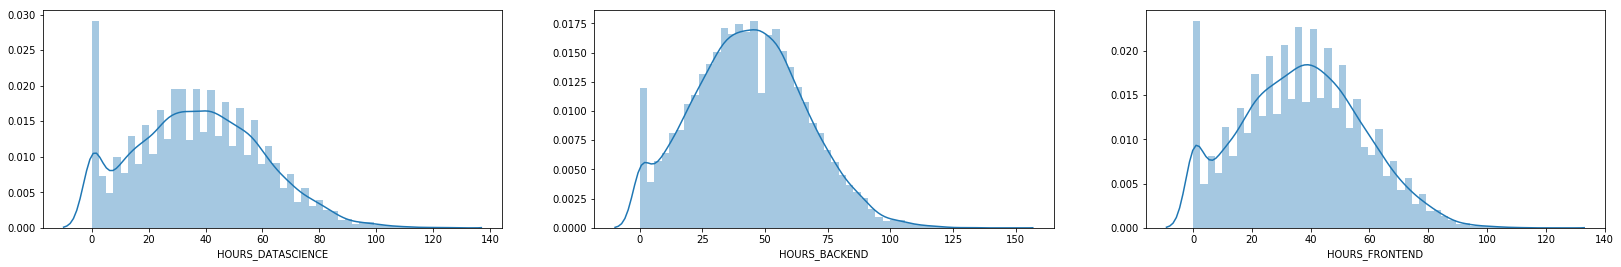

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

sns.distplot(df_data_1['HOURS_DATASCIENCE'].dropna(), ax=axes[0])
sns.distplot(df_data_1['HOURS_BACKEND'].dropna(), ax=axes[1])
sns.distplot(df_data_1['HOURS_FRONTEND'].dropna(), ax=axes[2])

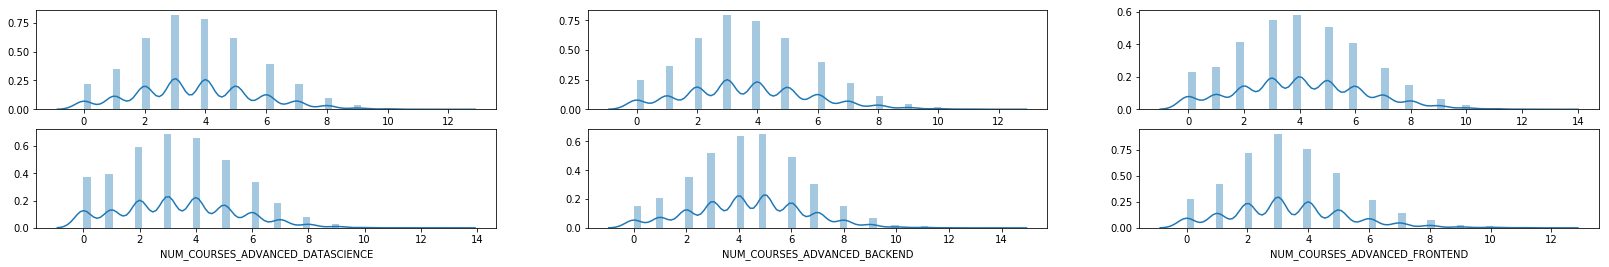

In [168]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(28, 4))

sns.distplot(df_data_1['NUM_COURSES_BEGINNER_DATASCIENCE'].dropna(), ax=axes[0][0])
sns.distplot(df_data_1['NUM_COURSES_BEGINNER_BACKEND'].dropna(), ax=axes[0][1])
sns.distplot(df_data_1['NUM_COURSES_BEGINNER_FRONTEND'].dropna(), ax=axes[0][2])
sns.distplot(df_data_1['NUM_COURSES_ADVANCED_DATASCIENCE'].dropna(), ax=axes[1][0])
sns.distplot(df_data_1['NUM_COURSES_ADVANCED_BACKEND'].dropna(), ax=axes[1][1])
sns.distplot(df_data_1['NUM_COURSES_ADVANCED_FRONTEND'].dropna(), ax=axes[1][2])

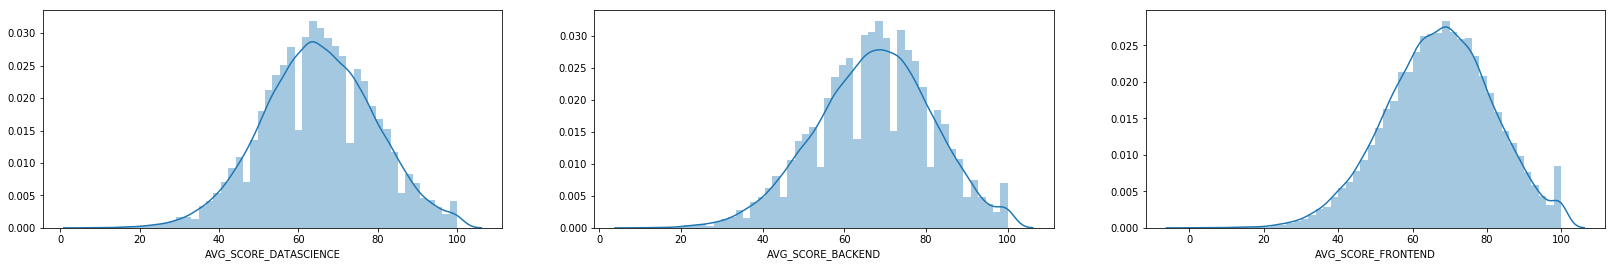

In [169]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

sns.distplot(df_data_1['AVG_SCORE_DATASCIENCE'].dropna(), ax=axes[0])
sns.distplot(df_data_1['AVG_SCORE_BACKEND'].dropna(), ax=axes[1])
sns.distplot(df_data_1['AVG_SCORE_FRONTEND'].dropna(), ax=axes[2])

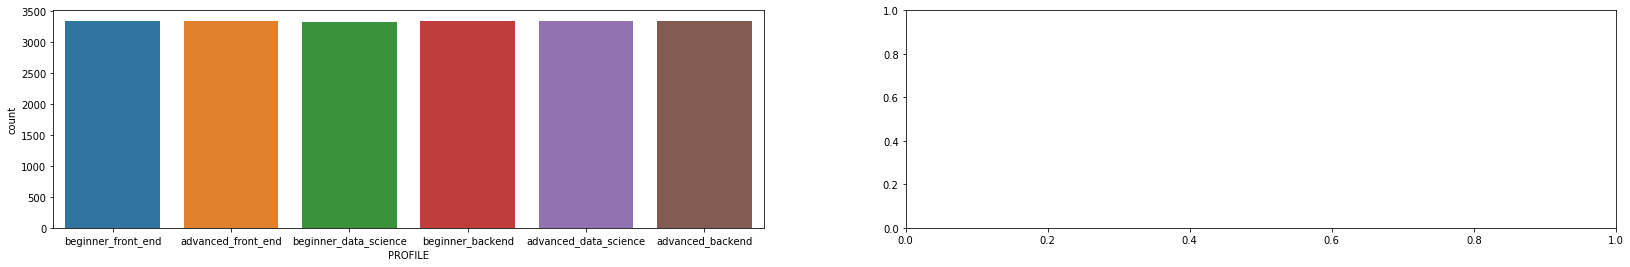

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 4))

sns.countplot(ax=axes[0], x='PROFILE', data=df_data_1)

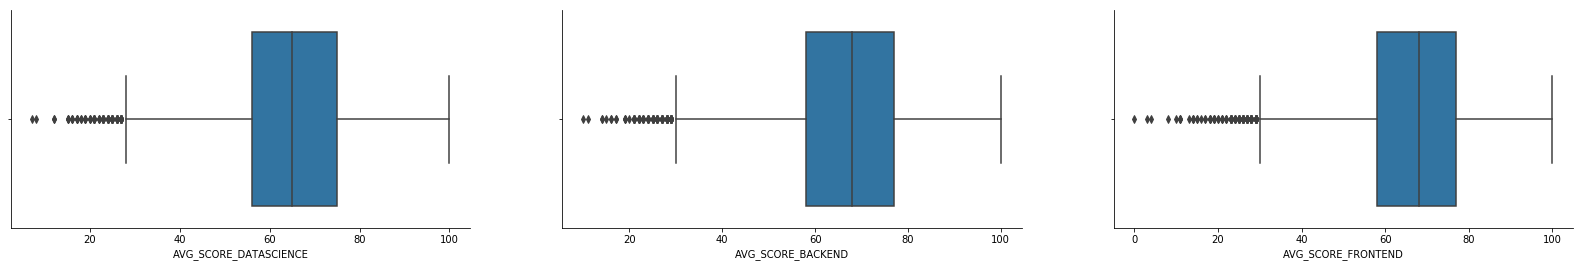

In [171]:
#Lets check outliers
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

sns.boxplot(df_data_1['AVG_SCORE_DATASCIENCE'], ax=axes[0])
sns.boxplot(df_data_1['AVG_SCORE_BACKEND'], ax=axes[1])
sns.boxplot(df_data_1['AVG_SCORE_FRONTEND'], ax=axes[2])
sns.despine()

### Preprocesamiento de datos

Para el preprocesamiento de los datos, se presentarán en este notebook dos transformaciones básicas, demostrando la construcción de un Pipeline con un modelo funcional. Este Pipeline funcional provisto debe ser mejorado por el participante para que el modelo final alcance la mayor precisión posible, garantizando una mayor puntuación en el desafío. Esta mejora solo se puede realizar en el preprocesamiento de los datos, en la elección de un algoritmo para el entrenamiento de diferentes modelos, o incluso en la alteración del **framework** utilizado (sin embargo, solo se entregará un ejemplo de integración de Watson Machine Learning con *scikit-learn*).

La primera transformación (paso en nuestro Pipeline) será la exclusión de la columna "NOMBRE" de nuestro conjunto de datos, que además de no ser una variable numérica, tampoco es una variable relacionada con el desempeño de los estudiantes en las disciplinas. Hay funciones listas para usar en *scikit-learn* para realizar esta transformación, sin embargo, nuestro ejemplo demostrará cómo crear una transformación personalizada desde cero en scikit-learn. Si lo desea, el participante puede usar este ejemplo para crear otras transformaciones y agregarlas al Pipeline final :)

#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos ``transform`` y ``fit``. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación ``DropColumns`` para eliminar columnas de un pandas DataFrame.

In [172]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

Para aplicar esa transformación en un pandas DataFrame pandas, basta instanciar un objeto *DropColumns* y llamar el método transform().

In [173]:
# Creación de instancias de una transformación DropColumns
rm_columns = DropColumns(
    columns=["NAME", "Unnamed: 0"]  # Esta transformación toma como parámetro una lista con los nombres de las columnas no deseadas
)

print(rm_columns)

DropColumns(columns=['NAME', 'Unnamed: 0'])


In [174]:
# Ver las columnas del conjunto de datos original
print("Columnas del conjunto de datos original: \n")
print(df_data_1.columns)

Columnas del conjunto de datos original: 

Index(['Unnamed: 0', 'NAME', 'USER_ID', 'HOURS_DATASCIENCE', 'HOURS_BACKEND',
       'HOURS_FRONTEND', 'NUM_COURSES_BEGINNER_DATASCIENCE',
       'NUM_COURSES_BEGINNER_BACKEND', 'NUM_COURSES_BEGINNER_FRONTEND',
       'NUM_COURSES_ADVANCED_DATASCIENCE', 'NUM_COURSES_ADVANCED_BACKEND',
       'NUM_COURSES_ADVANCED_FRONTEND', 'AVG_SCORE_DATASCIENCE',
       'AVG_SCORE_BACKEND', 'AVG_SCORE_FRONTEND', 'PROFILE'],
      dtype='object')


In [175]:
# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df_data_1)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df_data_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_data_1
    ),
)

In [176]:
# Ver las columnas del conjunto de datos transformado
print("Columnas del conjunto de datos después de la transformación ``DropColumns``: \n")
print(df_data_2.columns)

Columnas del conjunto de datos después de la transformación ``DropColumns``: 

Index(['USER_ID', 'HOURS_DATASCIENCE', 'HOURS_BACKEND', 'HOURS_FRONTEND',
       'NUM_COURSES_BEGINNER_DATASCIENCE', 'NUM_COURSES_BEGINNER_BACKEND',
       'NUM_COURSES_BEGINNER_FRONTEND', 'NUM_COURSES_ADVANCED_DATASCIENCE',
       'NUM_COURSES_ADVANCED_BACKEND', 'NUM_COURSES_ADVANCED_FRONTEND',
       'AVG_SCORE_DATASCIENCE', 'AVG_SCORE_BACKEND', 'AVG_SCORE_FRONTEND',
       'PROFILE'],
      dtype='object')


Tenga en cuenta que la columna "NOMBRE" se ha eliminado y nuestro conjunto de datos ahora solo tiene 14 columnas.

#### Transformación 2: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada **SimpleImputer**.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltantes.

#### Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='constant',  # la estrategia elegida es cambiar el valor faltante por una constante
    fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)

#### Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df_data_2.isnull().sum(axis = 0)))

#### Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=df_data_2)

#### Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df_data_3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df_data_2
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df_data_2.columns  # las columnas originales deben conservarse en esta transformación
)

#### Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("Valores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df_data_3.isnull().sum(axis = 0)))

Tenga en cuenta que ya no tenemos valores perdidos en nuestro conjunto de datos :)

Vale la pena señalar que cambiar los valores perdidos por 0 no siempre es la mejor estrategia. Se anima al participante a estudiar e implementar diferentes estrategias para tratar los valores perdidos para mejorar su modelo y mejorar su puntuación final.

### Entrenando un modelo de clasificación

Una vez finalizado el preprocesamiento, ya tenemos el conjunto de datos en el formato necesario para entrenar nuestro modelo:

In [179]:
#Crear un objeto SimpleImputer
si = SimpleImputer( missing_values=np.nan, # los valores que faltan son del tipo np.nan (Pandas estándar) 
                   strategy='constant', # la estrategia elegida es cambiar el valor faltante por una constante 
                   fill_value=0, # la constante que se usará para completar los valores faltantes es un int64 = 0 
                   verbose=0, 
                   copy=True
                  )

#Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df_data_2.isnull().sum(axis = 0)))

#Aplicamos el SimpleImputer si al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=df_data_2)

#Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df_data_3 = pd.DataFrame.from_records( 
    data=si.transform(
        X=df_data_2 
    ), # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista 
    columns=df_data_2.columns # las columnas originales deben conservarse en esta transformación 
)

#Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("Valores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df_data_3.isnull().sum(axis = 0)))
                                      
df_data_3.head()

print(df_data_3.count)

Valores nulos antes de la transformación SimpleImputer: 

USER_ID                               0
HOURS_DATASCIENCE                    14
HOURS_BACKEND                        53
HOURS_FRONTEND                       16
NUM_COURSES_BEGINNER_DATASCIENCE     26
NUM_COURSES_BEGINNER_BACKEND         18
NUM_COURSES_BEGINNER_FRONTEND        39
NUM_COURSES_ADVANCED_DATASCIENCE      2
NUM_COURSES_ADVANCED_BACKEND          8
NUM_COURSES_ADVANCED_FRONTEND        37
AVG_SCORE_DATASCIENCE               220
AVG_SCORE_BACKEND                    84
AVG_SCORE_FRONTEND                  168
PROFILE                               0
dtype: int64

Valores nulos en el conjunto de datos después de la transformación SimpleImputer: 

USER_ID                             0
HOURS_DATASCIENCE                   0
HOURS_BACKEND                       0
HOURS_FRONTEND                      0
NUM_COURSES_BEGINNER_DATASCIENCE    0
NUM_COURSES_BEGINNER_BACKEND        0
NUM_COURSES_BEGINNER_FRONTEND       0
NUM_COURSES_ADVANC

,USER_ID,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND,PROFILE
0,58283940,7.0,39.0,29.0,2.0,4.0,0.0,2.0,5.0,0.0,84.0,74.0,0.0,beginner_front_end
1,1357218,32.0,0.0,44.0,2.0,0.0,0.0,0.0,5.0,0.0,67.0,45.0,0.0,beginner_front_end
2,63212105,45.0,0.0,59.0,0.0,5.0,4.0,0.0,4.0,1.0,0.0,54.0,47.0,advanced_front_end
3,23239851,36.0,19.0,28.0,0.0,5.0,7.0,0.0,5.0,3.0,0.0,71.0,89.0,beginner_data_science
4,72234478,61.0,78.0,38.0,6.0,11.0,0.0,4.0,3.0,0.0,66.0,85.0,0.0,advanced_front_end


En el ejemplo proporcionado, usaremos todas las columnas, excepto la columna **Profile** como *feautres* (variables de entrada).

La variable **Profile** será la variable objetivo del modelo, como se describe en la declaración de desafío.

#### Definición de features del modelo

In [180]:
# Definición de las columnas que seran features (Notese que la columna NOMBRE no esta presente)
features = [
    "HOURS_DATASCIENCE", "HOURS_BACKEND", "HOURS_FRONTEND",
    "NUM_COURSES_BEGINNER_DATASCIENCE", "NUM_COURSES_BEGINNER_BACKEND", "NUM_COURSES_BEGINNER_FRONTEND",
    "NUM_COURSES_ADVANCED_DATASCIENCE", "NUM_COURSES_ADVANCED_BACKEND", "NUM_COURSES_ADVANCED_FRONTEND",
    "AVG_SCORE_DATASCIENCE", "AVG_SCORE_BACKEND", "AVG_SCORE_FRONTEND"
]

# Definición de variable objetivo
target = ['PROFILE']

# Preparación de los argumentos para los métodos de la biblioteca ``scikit-learn``
X = df_data_3[features]
y = df_data_3[target]

El conjunto de entrada (X):

In [181]:
X.head()

,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND
0,7.0,39.0,29.0,2.0,4.0,0.0,2.0,5.0,0.0,84.0,74.0,0.0
1,32.0,0.0,44.0,2.0,0.0,0.0,0.0,5.0,0.0,67.0,45.0,0.0
2,45.0,0.0,59.0,0.0,5.0,4.0,0.0,4.0,1.0,0.0,54.0,47.0
3,36.0,19.0,28.0,0.0,5.0,7.0,0.0,5.0,3.0,0.0,71.0,89.0
4,61.0,78.0,38.0,6.0,11.0,0.0,4.0,3.0,0.0,66.0,85.0,0.0


La variable objetivo (y):

In [182]:
y.head()

,PROFILE
0,beginner_front_end
1,beginner_front_end
2,advanced_front_end
3,beginner_data_science
4,advanced_front_end


#### Separar el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba

Separaremos el conjunto de datos provisto en dos grupos: uno para entrenar nuestro modelo y otro para probar el resultado a través de una prueba ciega. La separación del conjunto de datos se puede hacer fácilmente con el método *train_test_split ()* de scikit-learn:

In [183]:
from sklearn.model_selection import train_test_split

# Separación de datos en conjunto de entrenamiento y conjunto de pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=337)

#### Creando un modelo basado en árboles de decisión

En el ejemplo proporcionado, crearemos un clasificador basado en **árboles de decisión**.

El primer paso es básicamente crear una instancia de un objeto *DecisionTreeClassifier ()* de la biblioteca scikit-learn.

In [158]:
# Creando el árbol de decisiones con la biblioteca ``scikit-learn``:
dtc_model = DecisionTreeClassifier()  # El modelo se creará con los parámetros estándar de la biblioteca

# Entrenamiento de modelos (llamado método *fit ()* con conjuntos de entrenamiento)
dtc_model.fit(
    X_train,
    y_train
)

# Realización de una prueba a ciegas en el modelo creado
y_pred = dtc_model.predict(X_test)

#X_test.head()

#print(y_pred)

from sklearn.metrics import accuracy_score

# Precisión lograda por el árbol de decisiones
print("Exactitud: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

Exactitud: 75.0%


## My Improvements
I'm goin to use Pipeline: Imputer, Scaler, ElasticNet with CrossValidation and splitting in Test and Training Set

In [213]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#le = LabelEncoder()
#le.fit(df2.PROFILE.unique())
#df2.PROFILE = le.transform(df2.PROFILE)

#we use df_data_2 that is the original data without the name and the first param

#change the target value from categorical to numerical
df2 = df_data_2.copy()
#le = LabelEncoder()
#le.fit(df2.PROFILE.unique())
#df2.PROFILE = le.transform(df2.PROFILE)

#Remove User_ID
df2 = df2.drop('USER_ID', axis='columns')

#Scale the data
#scaler = StandardScaler()
#df2 = pd.DataFrame(scaler.fit_transform(df2.values), columns=df2.columns, index=df2.index)

df2.head()


,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND,PROFILE
0,7.0,39.0,29.0,2.0,4.0,0.0,2.0,5.0,0.0,84.0,74.0,NaN,beginner_front_end
1,32.0,0.0,44.0,2.0,0.0,0.0,0.0,5.0,0.0,67.0,45.0,NaN,beginner_front_end
2,45.0,0.0,59.0,0.0,5.0,4.0,0.0,4.0,1.0,NaN,54.0,47.0,advanced_front_end
3,36.0,19.0,28.0,0.0,5.0,7.0,0.0,5.0,3.0,NaN,71.0,89.0,beginner_data_science
4,61.0,78.0,38.0,6.0,11.0,0.0,4.0,3.0,0.0,66.0,85.0,NaN,advanced_front_end


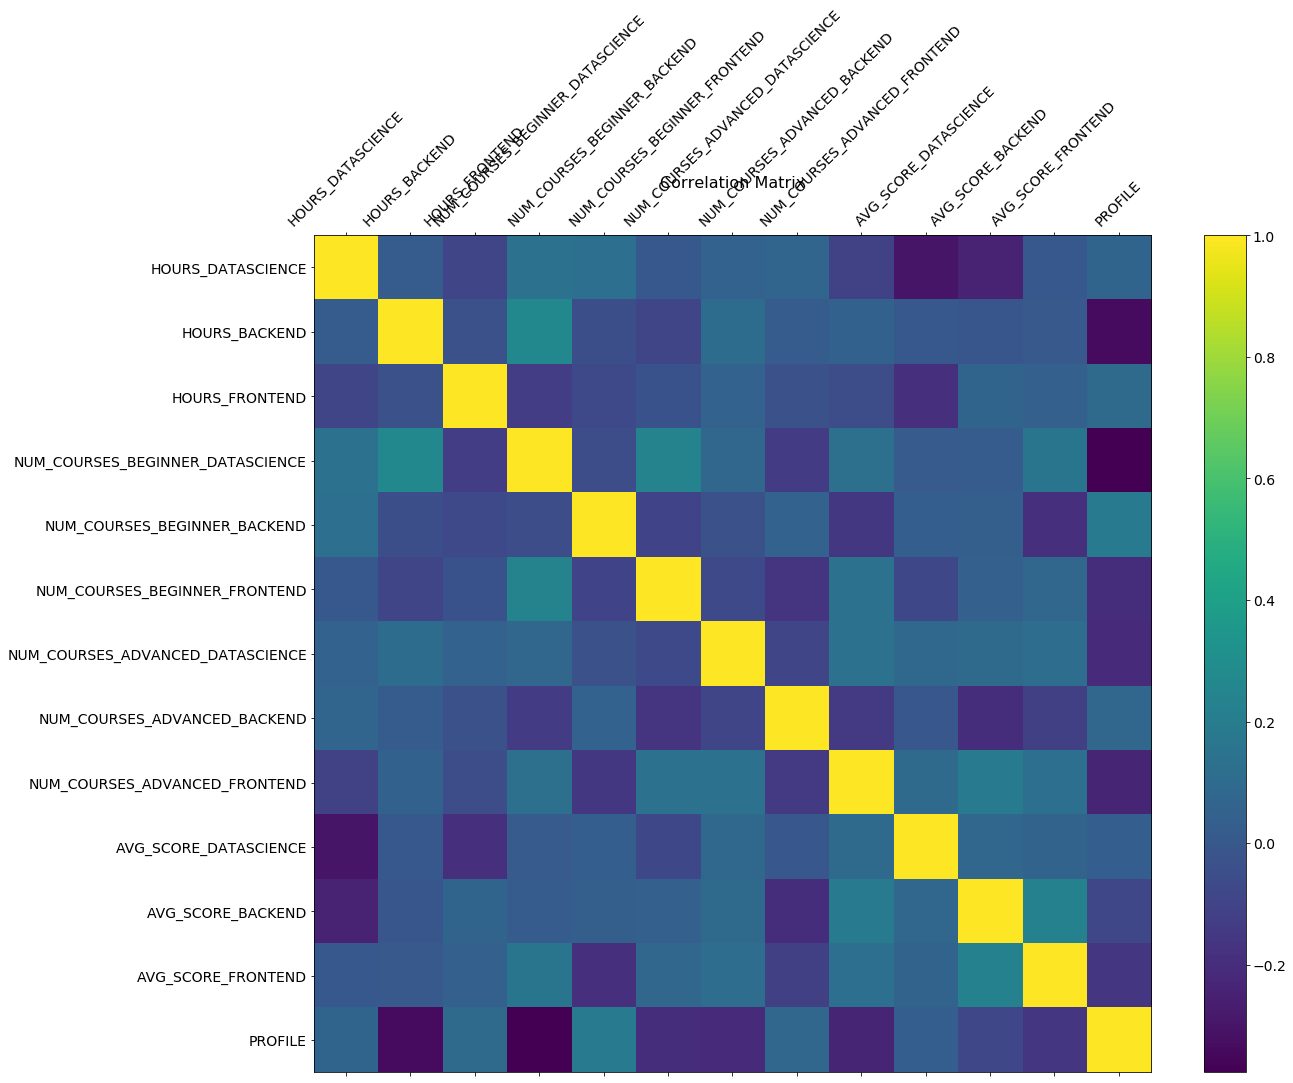

In [185]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(df2.corr(), fignum=f.number)
plt.xticks(range(df2.shape[1]), df2.columns, fontsize=14, rotation=45)
plt.yticks(range(df2.shape[1]), df2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [226]:
##Crearemos un Pipeline y usaremos un Imputer, un Scaler y ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#Crear un objeto SimpleImputer
si = SimpleImputer( missing_values=np.nan, # los valores que faltan son del tipo np.nan (Pandas estándar) 
                   strategy='median', # la estrategia elegida es cambiar el valor faltante por una constante
                   verbose=0, 
                   copy=True
                  )

#Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))
df2.shape

output = df2.PROFILE
temp = df2.drop('PROFILE', axis='columns')

#Aplicamos el SimpleImputer si al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=temp)

#Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df3 = pd.DataFrame.from_records( 
    data=si.transform(
        X=temp
    ), # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista 
    columns=temp.columns # las columnas originales deben conservarse en esta transformación 
)

df3['PROFILE'] = output

#Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("Valores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df3.isnull().sum(axis = 0)))
df3.shape

Valores nulos antes de la transformación SimpleImputer: 

HOURS_DATASCIENCE                    14
HOURS_BACKEND                        53
HOURS_FRONTEND                       16
NUM_COURSES_BEGINNER_DATASCIENCE     26
NUM_COURSES_BEGINNER_BACKEND         18
NUM_COURSES_BEGINNER_FRONTEND        39
NUM_COURSES_ADVANCED_DATASCIENCE      2
NUM_COURSES_ADVANCED_BACKEND          8
NUM_COURSES_ADVANCED_FRONTEND        37
AVG_SCORE_DATASCIENCE               220
AVG_SCORE_BACKEND                    84
AVG_SCORE_FRONTEND                  168
PROFILE                               0
dtype: int64

Valores nulos en el conjunto de datos después de la transformación SimpleImputer: 

HOURS_DATASCIENCE                   0
HOURS_BACKEND                       0
HOURS_FRONTEND                      0
NUM_COURSES_BEGINNER_DATASCIENCE    0
NUM_COURSES_BEGINNER_BACKEND        0
NUM_COURSES_BEGINNER_FRONTEND       0
NUM_COURSES_ADVANCED_DATASCIENCE    0
NUM_COURSES_ADVANCED_BACKEND        0
NUM_COURSES_ADVANCED

(20000, 13)

In [227]:
df2.describe()

,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND
count,19986.000000,19947.000000,19984.000000,19974.000000,19982.000000,19961.000000,19998.000000,19992.000000,19963.00000,19780.000000,19916.000000,19832.000000
mean,37.565296,43.552263,36.936599,3.698608,3.715144,4.048294,3.397140,4.344338,3.36783,65.070324,67.234535,67.130748
std,22.394805,22.387518,20.590381,2.001647,2.101863,2.296000,2.111437,2.161569,1.98784,13.950559,14.214591,14.446830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7.000000,10.000000,0.000000
25%,21.000000,28.000000,22.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.00000,56.000000,58.000000,58.000000
50%,37.000000,43.000000,37.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.00000,65.000000,68.000000,68.000000
75%,53.000000,59.000000,51.000000,5.000000,5.000000,6.000000,5.000000,6.000000,5.00000,75.000000,77.000000,77.000000
max,127.000000,147.000000,124.000000,12.000000,12.000000,13.000000,13.000000,14.000000,12.00000,100.000000,100.000000,100.000000


In [228]:
df3.describe()

,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND
count,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,37.56490,43.550800,36.936650,3.699000,3.715400,4.048200,3.397100,4.344200,3.367150,65.069550,67.237750,67.138050
std,22.38697,22.357851,20.582143,2.000375,2.100934,2.293761,2.111335,2.161148,1.986063,13.873617,14.184794,14.386241
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,10.000000,0.000000
25%,21.00000,28.000000,22.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,56.000000,58.000000,58.000000
50%,37.00000,43.000000,37.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,65.000000,68.000000,68.000000
75%,53.00000,59.000000,51.000000,5.000000,5.000000,6.000000,5.000000,6.000000,5.000000,74.000000,77.000000,77.000000
max,127.00000,147.000000,124.000000,12.000000,12.000000,13.000000,13.000000,14.000000,12.000000,100.000000,100.000000,100.000000


In [233]:
import numpy as np
from sklearn.pipeline import Pipeline

#Pipeline
#pipeline = Pipeline(steps)

#hyperparameters
#parameters = {'elasticnet__l1_ratio': np.linspace(-1,1,30)}
#parameters = {'SVM__C': [1,100],'SVM_gamma': [0.1,0.01]}

df3.head()

,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND,PROFILE
0,7.0,39.0,29.0,2.0,4.0,0.0,2.0,5.0,0.0,84.0,74.0,68.0,beginner_front_end
1,32.0,0.0,44.0,2.0,0.0,0.0,0.0,5.0,0.0,67.0,45.0,68.0,beginner_front_end
2,45.0,0.0,59.0,0.0,5.0,4.0,0.0,4.0,1.0,65.0,54.0,47.0,advanced_front_end
3,36.0,19.0,28.0,0.0,5.0,7.0,0.0,5.0,3.0,65.0,71.0,89.0,beginner_data_science
4,61.0,78.0,38.0,6.0,11.0,0.0,4.0,3.0,0.0,66.0,85.0,68.0,advanced_front_end


In [238]:
from sklearn.model_selection import train_test_split
import numpy as np

# Definición de las columnas que seran features (Notese que la columna NOMBRE no esta presente)
features = [
    "HOURS_DATASCIENCE", "HOURS_BACKEND", "HOURS_FRONTEND",
    "NUM_COURSES_BEGINNER_DATASCIENCE", "NUM_COURSES_BEGINNER_BACKEND", "NUM_COURSES_BEGINNER_FRONTEND",
    "NUM_COURSES_ADVANCED_DATASCIENCE", "NUM_COURSES_ADVANCED_BACKEND", "NUM_COURSES_ADVANCED_FRONTEND",
    "AVG_SCORE_DATASCIENCE", "AVG_SCORE_BACKEND", "AVG_SCORE_FRONTEND"
]

# Definición de variable objetivo
target = ['PROFILE']

# Preparación de los argumentos para los métodos de la biblioteca ``scikit-learn``
X = df3[features]
y = df3[target]

# Separación de datos en conjunto de entrenamiento y conjunto de pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=337)

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)
pipeline.score(X_test, y_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7055

Este notebook demostró cómo trabajar con transformaciones y modelos con la biblioteca scikit-learn. Se recomienda que el participante realice sus experimentos editando el código proporcionado aquí hasta lograr un modelo con alta precisión.

Cuando esté satisfecho con su modelo, puede pasar al segundo paso del desafío: encapsular su modelo como una API REST lista para usar con Watson Machine Learning.

El notebook para la segunda etapa ya está en este proyecto, simplemente acceda a la pestaña **ASSETS** e inícielo. No olvide apagar primero el Kernel en este portátil para reducir el consumo de su nivel gratuito de IBM Cloud Pak for Data.

In [241]:
import numpy as np
from sklearn                        import metrics, svm
from sklearn.linear_model           import LinearRegression
from sklearn.linear_model           import LogisticRegression
from sklearn.tree                   import DecisionTreeClassifier
from sklearn.neighbors              import KNeighborsClassifier
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
from sklearn.naive_bayes            import GaussianNB
from sklearn.svm                    import SVC
from sklearn.ensemble import RandomForestClassifier

clf = LogisticRegression()
clf.fit(X_train, y_train.values.ravel())
print("LogisticRegression")
y_pred = clf.predict(X_test)
print("Exactitud: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train.values.ravel())
print("DecisionTreeClassifier")
y_pred = clf.predict(X_test)
print("Exactitud: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

clf = KNeighborsClassifier()
clf.fit(X_train, y_train.values.ravel())
print("KNeighborsClassifier")
y_pred = clf.predict(X_test)
print("Exactitud: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train.values.ravel())
print("RandomForestClassifier")
y_pred=clf.predict(X_test)
print("Exactitud: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression
Exactitud: 71.0%
DecisionTreeClassifier
Exactitud: 74.0%
KNeighborsClassifier
Exactitud: 74.0%
RandomForestClassifier
Exactitud: 91.0%
